# Capstone 1 Final Report
### by Drew Adamski

The NBA is an increasingly analytical league. Taking note of the "Sabremetric" revolution of baseball, more and more NBA teams are looking to advanced analytics to give them an edge. This has led to changes in the way the game is played on the floor as well as how it is talked about in front offices.

An under discussed part of NBA scouting, and one with great yields, is to use analytics to predict jumps in production from players that are already in the league. The central question of my project is as follows:

**Given a player’s statistics from a single season, can I predict whether that player will be an all-star the following year?**

Answering this question greatly benefits general managers around the league who could implement new strategies of data analytics to identify players that may potentially break out the following season. Anything to give a team potential insight that other organizations do not have would be incredibly valuable to teams as they vie for the NBA Championship.

## Data Wrangling

To answer this question I required accurate and complete season data in order to make my predictions. I was unable to find a preprocessed dataset online that fit my question, so I opted instead to create my own through web scraping.
    
Using BeautifulSoup python package, I pulled season data for a list of 310 players from www.basketball-reference.com. There were many issues that came up during this process, so I performed additional cleaning after scraping the data which included fixing errors from the scraping process, imputing data, handling extreme cases. Following this process, I could begin exploring the data.

(A more detailed breakdown of this process can be found in `scrape-basketball-reference.ipynb`. Final cleaning steps can be found in `cleaning.py` from which I import `df` for the rest of my analysis.)

## Exploratory Data Analysis
I wanted to take a look at the distribution of values for each statistic to understand what the probability densities looked like. I found that the distributions of the variables in my dataset took on a variety of forms. While many had approximately normal distributions, there were some surprising ones.

The whole purpose of this project is to make a prediction, so at this point it was time that I see what variables have a strong correlation with my target variable. I had created some scatter plots to see if there were any noticeable delineations of players that were allstars and those that were not

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from statsmodels.stats import weightstats

from cleaning import df

# Set graph style to Seaborn's default
sns.set()

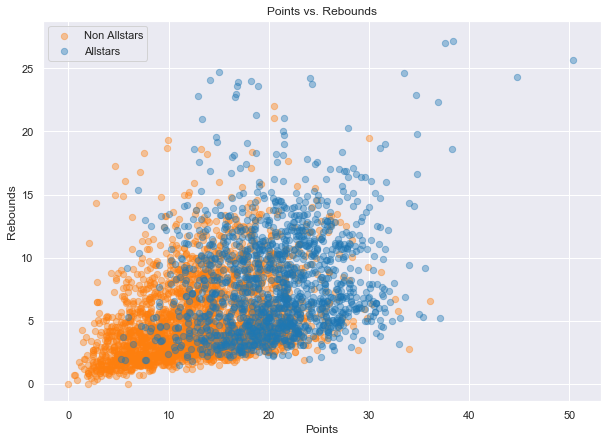

In [24]:
_ = plt.figure(figsize=(10, 7))
_ = plt.scatter(x=df[df['allstar_next']==0].pts, y=df[df['allstar_next']==0].trb, 
                color='tab:orange', label='Non Allstars', alpha=0.4, s=40)
_ = plt.scatter(x=df[df['allstar_next']==1].pts, y=df[df['allstar_next']==1].trb, 
                color='tab:blue', label='Allstars', alpha=0.4, s=40)
#_ = sns.scatterplot(x='pts', y='trb', hue='allstar_next', data=df, alpha=0.4)
_ = plt.title('Points vs. Rebounds')
_ = plt.xlabel('Points')
_ = plt.ylabel('Rebounds')
_ = plt.legend()

I ran a correlation test on my data and extracted the allstar_next column exclusively to figure out the relationships. I found that all the columns associated with scoring (points, field goal attempts, free throws, etc.) had a strong, positive correlation with my target variable. It was in this moment that I realized there were definite problems with some of the columns of my data being highly related to each other in fundamental ways that I will need to be cognizant of when I build my model.

In [25]:
eda_df = df.drop(['player', 'href', 'tm', 'lg', 'pos'], axis=1)
allstar = eda_df[eda_df.allstar_next == 1]
nostar = eda_df[eda_df.allstar_next == 0]

h_o = zip(allstar.columns, weightstats.ztest(nostar, allstar)[1])

def sig(value, alpha):
    if value < alpha:
        return 'Significant'
    else:
        return 'Not significant'
    
print('Column: p-value')
for i in list(h_o):
    print(i[0], ':', sig(i[1], 0.00172))

Column: p-value
height : Significant
age : Significant
g : Significant
gs : Significant
mp : Significant
fg : Significant
fga : Significant
fgp : Significant
threep : Not significant
threepa : Not significant
threepp : Not significant
twop : Significant
twopa : Significant
twopp : Significant
efgp : Significant
ft : Significant
fta : Significant
ftp : Significant
orb : Significant
drb : Significant
trb : Significant
ast : Significant
stl : Significant
blk : Significant
tov : Significant
pf : Significant
pts : Significant
allstar : Significant
years_in_league : Significant
allstar_next : Significant


C:\Users\Drew\Anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:655: RuntimeWarning: divide by zero encountered in true_divide
  zstat = (value1 - value2 - diff) / std_diff


In nearly every single category, there is a significant difference between allstars and non allstars. The only one's that are not significantly different are `threep`, `threepa`, and `threepp`. These significant differences make me believe that there is a way to predict whether a player will be an allstar the following year or not.

Next I checked the correlations between different values and the `allstar_next` column. I sorted it, so I could see which columns are most highly correlated.

In [26]:
df.corr()['allstar_next'].sort_values(ascending=False)

allstar_next       1.000000
pts                0.546165
fta                0.539407
allstar            0.539254
twop               0.536244
ft                 0.535652
fg                 0.533772
twopa              0.532829
fga                0.520361
mp                 0.480490
tov                0.391429
trb                0.358191
gs                 0.307168
pf                 0.294944
drb                0.294126
stl                0.253929
ast                0.237974
blk                0.233708
orb                0.221153
g                  0.202099
fgp                0.127843
efgp               0.098608
height             0.087311
twopp              0.066376
ftp                0.058440
threepa           -0.003463
threep            -0.003992
threepp           -0.013500
age               -0.194724
years_in_league   -0.204990
Name: allstar_next, dtype: float64

I also want to add columns representing the positions of each player. I do so by creating dummy variables for the `pos` column.

In [27]:
df = pd.get_dummies(df, columns=['pos'])

# Feature Selection
There are 3 different methods of feature selection that I will consider: `VarianceThreshold`, `SelectKBest`, and `SelectFromModel`.

`VarianceThreshold` removes all features with a variance equal to 0. Since I do not have any columns with the same values throughout, this will not help me reduce the dimensionality of my dataset.

`SelectKBest` selects a defined number of categories, k, that are most descriptive of the data. For classification problems, there are 3 types of tests that can be run to score the features: `chi2`, `f_classif`, and `mutual_info_classif`. `chi2` uses a $\chi^{2}$ test to measure dependence between stochastic varables, so this function removes features that are most likely to be independent of class and therefore irrelevant to classification. However, it requires all positive values, and when I scale my data, some values are below 0.  `f_classif` calculates the ANOVA F-value for the sample which is the ratio of two features' variance. `mutual_info_classif` estimates mutual information for a discrete target variable. If MI between two random variables is 0, they are independent, and a high MI means higher dependency.

For my purposes, I will use `SelectKBest` and use `mutual_info_classif` to determine the best features.

To begin, I set `int_df` equal to the numeric columns of my dataset. I then split it into the feature columns and the target column, `allstar_next`. I then separate each of these new dataframes into training datasets and test datasets. I use StandardizedScaler to preprocess the feature dataset. The target data is binary so no standardization is necesary.

In order to prevent leakage in my model, I fit it to the training set ONLY, and then use this fitted model to transform both the training and test sets.

In [28]:
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                random_state=13, 
                                                stratify=target)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)


skb = SelectKBest(mutual_info_classif, k=features.shape[1])
skb.fit(Xtrain, ytrain)
mask = skb.get_support()
kbestfeat = list()

for boolean, feature in zip(mask, int_df.columns):
    if boolean:
        kbestfeat.append(feature)

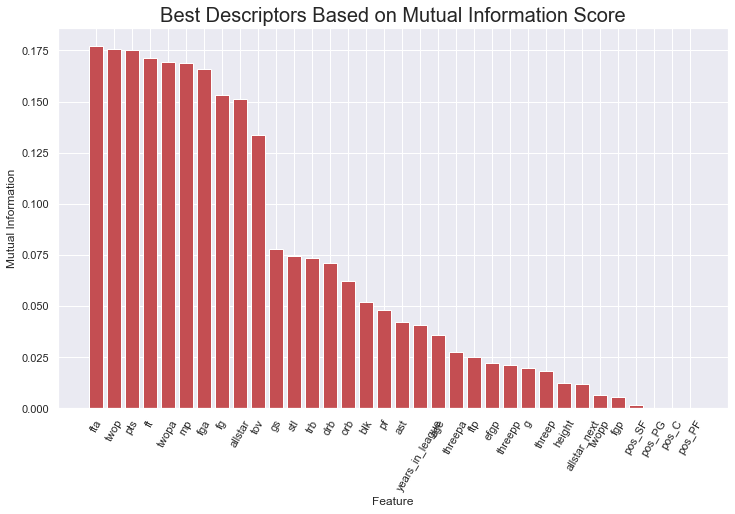

In [29]:
indices = np.argsort(skb.scores_)[::-1]
cols = []
for i in range(34):
    cols.append(int_df.columns[indices[i]])

# Now plot
_ = plt.figure(figsize=[12,7])
_ = plt.bar(cols, skb.scores_[indices[range(34)]], color='r', align='center')
_ = plt.xticks(rotation=60)
_ = plt.title('Best Descriptors Based on Mutual Information Score', size=20)
_ = plt.xlabel('Feature')
_ = plt.ylabel('Mutual Information')
_ = plt.show()

My 10 most descriptive features are: `fta`, `ft`, `twop`, `fg`, `twopa`, `allstar`, `fga`, `mp`, `tov`, and `gs`. However, I don't know if feature selection is even the best option for me. In order to check this, I will run some tests on the ability of my model to correctly predict my data using different number of features

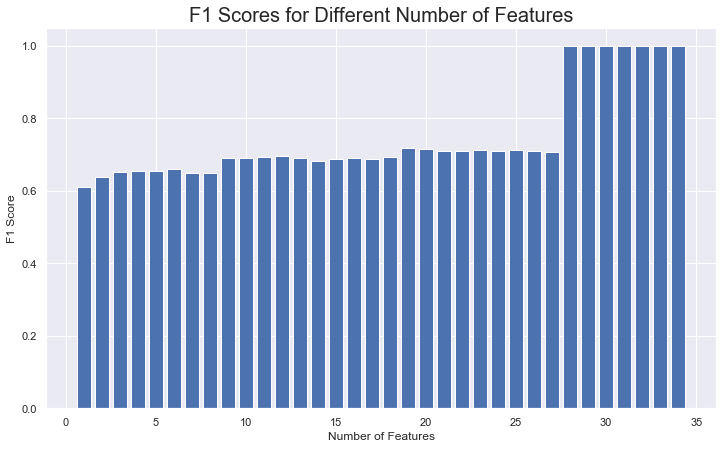

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
lr = LogisticRegression(max_iter=10000, solver='lbfgs')
pipeline = make_pipeline(scaler, lr)

f1s = []
for i in range(1, len(kbestfeat)+1):
    
    features = int_df[cols[:i]].values
    target = int_df.loc[:, 'allstar_next'].values

    Xtrain, Xtest, ytrain, ytest = train_test_split(features, target,
                                                    random_state=13, 
                                                    stratify=target)
    
    pipeline.fit(Xtrain, ytrain)
    ypred = pipeline.predict(Xtest)
    
    f1s.append(f1_score(ytest, ypred))
    
plt.figure(figsize=(12,7))
plt.bar(x=range(1, len(kbestfeat)+1), height=f1s);
plt.title('F1 Scores for Different Number of Features', size=20);
plt.xlabel('Number of Features');
plt.ylabel('F1 Score');

Since there is an initial increase in prediction power and then very small increases with more features until all features are then included, I am not going to reduce the dimensionality of my dataset further than I already have. Increased information will hopefully help me tune my model more effectively.

# Model Selection

I will be looking at 4 different machine learning models to classify my data:

- `LogisticRegression`
- `RandomForestClassifier`
- `SVC`
- `KNeighborsClassifier`

I tuned the hyperparameters each of these using `GridSearchCV`. Though I considered using `RandomizedSearchCV`, the parameter grids I created were not complicated to the point where Grid Search became time prohibitive.

# Logistic Regression
There are a variety of parameters for logistic regression, but many of them do not apply to my question for a variety of reasons or I have made a selection based on the scikit-learn documentation. For instance, while there are many potential solvers many do not make sense for my project. `sag` and `saga` are for very large datasets. Given that I do not have an excess of columns, I want to use L2 penalty rather than L1 which could induce too much sparsity. Using `newton-cg` comes with many problems such as being computationally expensive and being attracted to Saddle Points where it can become confused about whether the input is a maximum or minimum. This leaves me with `liblinear` and `lbfgs`. I will use `lbfgs` because it is the default setting for `LogisticRegression` and will serve my purposes well.

I determined the following parameters to be most important for my model construction:
- `C`
- `fit_intercept`

I chose to use GridSearchCV over RandomizedSearchCV because the range of parameters and the size of my dataset is not so large as to cause problems. My scoring metric to determine the best model will be the F1 score because in my dataset, there are more seasons where the next year a player is not an allstar than there are seasons where a player is. Looking at accuracy alone would artificially inflate the models success rate.

Based off of the grid search results, my parameters for the model should be:
- `C`: 10e8
- `fit_intercept`: False

I now want to test my model's effectiveness at predicting new data. Below I set up a pipeline to standardize the data and then perform logistic regression on the test samples. I will then produce a confusion matrix, classification report, and ROC curve.

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                stratify=target)
scaler = StandardScaler()

lr = LogisticRegression(C=10e8, fit_intercept=False,
                       max_iter=10000, solver='lbfgs')

pipeline = make_pipeline(scaler, lr)

pipeline.fit(Xtrain, ytrain)
ypred = pipeline.predict(Xtest)
yproblr = pipeline.predict_proba(Xtest)


print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))

[[453 160]
 [ 60 292]]
              precision    recall  f1-score   support

         0.0       0.88      0.74      0.80       613
         1.0       0.65      0.83      0.73       352

    accuracy                           0.77       965
   macro avg       0.76      0.78      0.77       965
weighted avg       0.80      0.77      0.78       965



In [32]:
from sklearn.metrics import auc, precision_recall_curve, roc_curve

fprlr, tprlr, threshold = roc_curve(ytest, ypred)
roc_auclr = auc(fprlr, tprlr)

yproblr = yproblr[:, 1]
precisionlr, recalllr, thresholdslr = precision_recall_curve(ytest, yproblr)
pr_auclr = auc(recalllr, precisionlr)

# Random Forest Classifier
I now want to explore using a Random Forest Classifier on my data. `RandomForestClassifer` has even more parameters than `LogisticRegression`, so I will use `RandomizedSearchCV` for this testing. After looking through the documentation, I believe the following parameters are most important to do grid search on:

`n_estimators` represents the number of trees in the forest. With more trees, the model better learns the data, but having too many leads to overfitting and slows down the training process considerably.

`max_depth` is how many splits each tree will have. If it is too high, then the model overfits to the training data.

`max_features` represents the number of features to consider when looking for the best split. At high values, it leads to overfitting.

To get an idea of what values to use for n_estimators and max_depth, I wanted to graph how the changes in their values affect the ability of my model accuracy. I used the ROC AUC to test.

Based on my grid search, max_depth = 5 and n_estiamtors = 50

In [33]:
from sklearn.ensemble import RandomForestClassifier

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target,
                                               stratify=target,
                                               random_state=13)

scaler = StandardScaler()
rfc = RandomForestClassifier(n_estimators=50, max_depth=6, bootstrap=True)
pipeline = make_pipeline(scaler, rfc)

pipeline.fit(Xtrain, ytrain)
ypred = pipeline.predict(Xtest)
yprobrfc = pipeline.predict_proba(Xtest)

print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))


[[524  89]
 [112 240]]
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84       613
         1.0       0.73      0.68      0.70       352

    accuracy                           0.79       965
   macro avg       0.78      0.77      0.77       965
weighted avg       0.79      0.79      0.79       965



It would be valuable to visualize the relative importance of each feature in deciding the classification of each datapoint. Doing so creates the following graph.

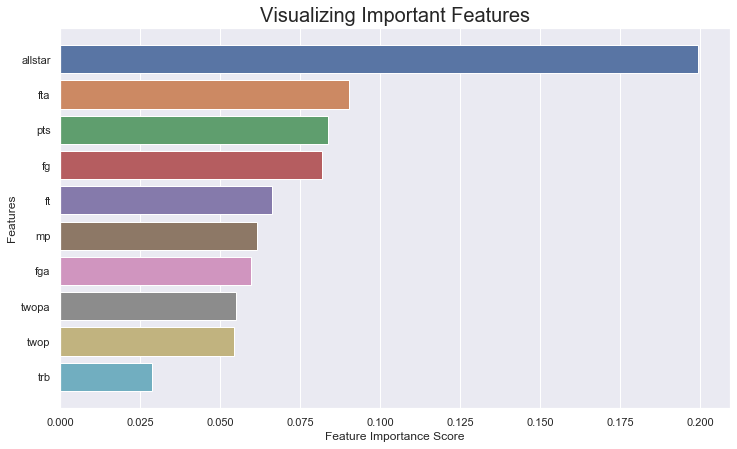

In [34]:
feature_imp = pd.Series(rfc.feature_importances_, index=features.columns).sort_values(ascending=False)
_ = plt.figure(figsize=(12,7))
_ = sns.barplot(x=feature_imp[:10], y=feature_imp[:10].index)
_ = plt.xlabel('Feature Importance Score')
_ = plt.ylabel('Features')
_ = plt.title('Visualizing Important Features', size=20)
_ = plt.plot()

The top three features make sense logically. If a player is an all star the previous year, there is a high likelihood they will repeat. Additionally, all stars are high scorers who play a lot of minutes for their teams.

In [35]:
fprrfc, tprrfc, threshold = roc_curve(ytest, ypred)
roc_aucrfc = auc(fprrfc, tprrfc)

yprobrfc = yprobrfc[:, 1]
precisionrfc, recallrfc, thresholdsrfc = precision_recall_curve(ytest, yprobrfc)
pr_aucrfc = auc(recallrfc, precisionrfc)

# Support Vector Machine
Support Vector Machines construct a hyperplane of set of hyperplanes in higher dimensional space in order to classify the data. For my model I will be looking at the value of the penalty term `C` and the `kernel`. There are a few different types of kernels available to use with Support Vector Machines, and I will be testing `rbf` and `poly` kernels to see which is best for my models.

The best C value for SVM is 1 and the best kernel for me to use is rbf

In [36]:
from sklearn.svm import SVC

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                stratify=target,
                                               random_state=13)
scaler = StandardScaler()

svm = SVC(gamma='scale', C=1, kernel='rbf', probability=True)

pipeline = make_pipeline(scaler, svm)

pipeline.fit(Xtrain, ytrain)
ypred = pipeline.predict(Xtest)
yprobsvm = pipeline.predict_proba(Xtest)

print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))


[[510 103]
 [109 243]]
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.83       613
         1.0       0.70      0.69      0.70       352

    accuracy                           0.78       965
   macro avg       0.76      0.76      0.76       965
weighted avg       0.78      0.78      0.78       965



In [37]:
fprsvm, tprsvm, threshold = roc_curve(ytest, ypred)
roc_aucsvm = auc(fprsvm, tprsvm)

yprobsvm = yprobsvm[:, 1]
precisionsvm, recallsvm, thresholdssvm = precision_recall_curve(ytest, yprobsvm)
pr_aucsvm = auc(recallsvm, precisionsvm)


# K Nearest Neighbors Classifier

K Nearest Neighbors Classifier classifies points based the points surrounding it. Depending on the number of neighbors considered, a simple majority is taken and the point is then classified according to the winning category. If the number of neighbors considered is high, noise is less pronounced, but the boundaries are less defined. The opposite is true for a low number of neighbors, and overfitting becomes a problem.

I tested a variety of values for `n_neighbors`, `p`, and `weights` in order to fine tune my model. Through Grid Search Cross Validation, I selected the following parameter values:

`n_neighbors`: 30

`p`: 1

`weights`: 'distance'

In [38]:
from sklearn.neighbors import KNeighborsClassifier

int_df = df.select_dtypes(exclude=object)
features = int_df.loc[:, int_df.columns != 'allstar_next']
target = int_df.loc[:, 'allstar_next']

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                stratify=target,
                                               random_state=13)
scaler = StandardScaler()

knc = KNeighborsClassifier(n_neighbors=30, p=1, weights='distance')

pipeline = make_pipeline(scaler, knc)

pipeline.fit(Xtrain, ytrain)
ypred = pipeline.predict(Xtest)
yprobknc = pipeline.predict_proba(Xtest)

print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))


[[516  97]
 [109 243]]
              precision    recall  f1-score   support

         0.0       0.83      0.84      0.83       613
         1.0       0.71      0.69      0.70       352

    accuracy                           0.79       965
   macro avg       0.77      0.77      0.77       965
weighted avg       0.79      0.79      0.79       965



In [39]:
fprknc, tprknc, thresholdknc = roc_curve(ytest, ypred)
roc_aucknc = auc(fprknc, tprknc)

yprobknc = yprobknc[:, 1]
precisionknc, recallknc, thresholdsknc = precision_recall_curve(ytest, yprobknc)
pr_aucknc = auc(recallknc, precisionknc)

# Model Comparison

In order to understand which model performs best, I looked at Receiving Operating Characteristic and Precision-Recall curves. ROC curves measure how the True Positive Rate changes in respect to the False Positive Rate. The area under the curve is then calculated. Models with AUC closer to 1 are better than lower AUC. Precision-Recall curves show the change in Precision as Recall increases. AUC is used for this curve as well to compare models. 

ROC curves are great for classification problems as are Precision-Recall curves, but ROC AUC can be artificially inflated in unbalanced datasets which can be mitigated by using a Precision-Recall Curve. I have created both since my data is a little unbalanced.

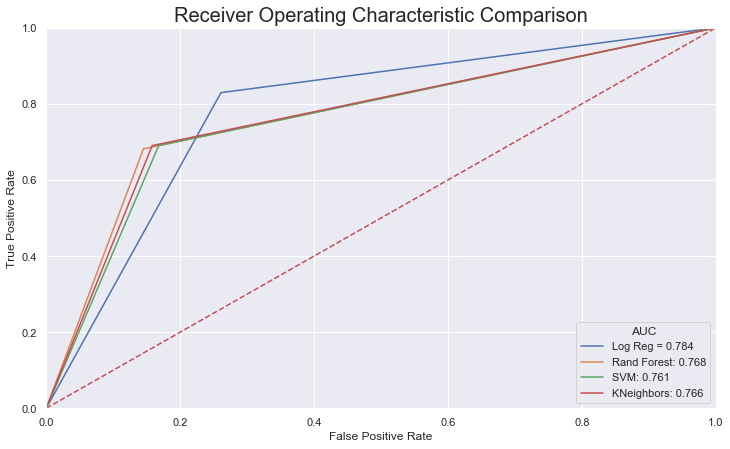

In [40]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Receiver Operating Characteristic Comparison', size=20)
_ = plt.plot(fprlr, tprlr, label = 'Log Reg = %0.3f' % roc_auclr)
_ = plt.plot(fprrfc, tprrfc, label='Rand Forest: %0.3f' % roc_aucrfc)
_ = plt.plot(fprsvm, tprsvm, label='SVM: %0.3f' % roc_aucsvm)
_ = plt.plot(fprknc, tprknc, label='KNeighbors: %0.3f' % roc_aucknc)
_ = plt.legend(title='AUC', loc = 'lower right')
_ = plt.plot([0, 1], [0, 1],'r--')
_ = plt.xlim([0, 1])
_ = plt.ylim([0, 1])
_ = plt.ylabel('True Positive Rate')
_ = plt.xlabel('False Positive Rate')
_ = plt.show()

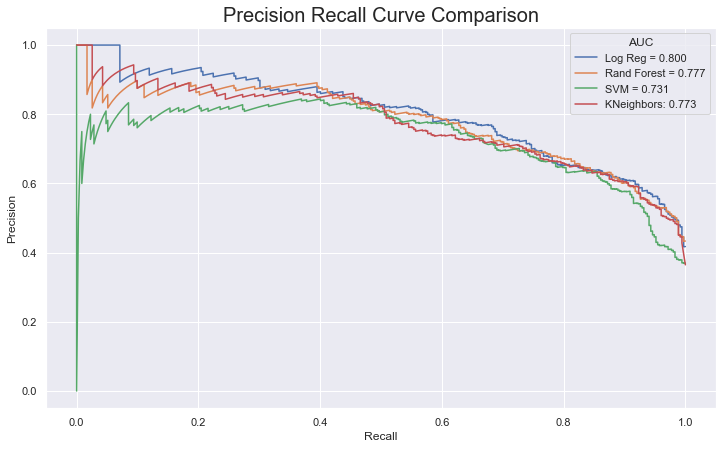

In [41]:
_ = plt.figure(figsize=(12,7))
_ = plt.title('Precision Recall Curve Comparison', size=20)
_ = plt.plot(recalllr, precisionlr, label = 'Log Reg = %0.3f' % pr_auclr)
_ = plt.plot(recallrfc, precisionrfc, label = 'Rand Forest = %0.3f' % pr_aucrfc)
_ = plt.plot(recallsvm, precisionsvm, label = 'SVM = %0.3f' % pr_aucsvm)
_ = plt.plot(recallknc, precisionknc, label = 'KNeighbors: %0.3f' % pr_aucknc)
#_ = plt.xlim([0, 1])
#_ = plt.ylim([0, 1])
_ = plt.ylabel('Precision')
_ = plt.xlabel('Recall')
_ = plt.legend(title='AUC')
_ = plt.show()

In [42]:
auc_df = pd.DataFrame({
    'ROC AUC': [roc_auclr, roc_aucrfc, roc_aucsvm, roc_aucknc],
    'Prec-Rec': [pr_auclr, pr_aucrfc, pr_aucsvm, pr_aucknc]
}, index=['Log Reg', 'Rand Forest', 'SVM', 'KNeighbors'])

In [43]:
auc_df

,ROC AUC,Prec-Rec
Log Reg,0.784267,0.799670
Rand Forest,0.768315,0.777094
SVM,0.761157,0.730711
KNeighbors,0.766051,0.772679


Based on both metrics, Logistic Regression is the most effective model at predicting whether a player will be an all star the following year or not. The worst was Support Vector Machines.

# WHY IS THAT?

# Misclassifications

A huge question I have after modeling my data is what data points were misclassified. There may be a trend there that could help me identify why my model is not performing as well as I would hope. To do so, I am going to split my data and train each model. From there I will predict values and compare which seasons were misclassified across all three models.

In [44]:
Xtrain, Xtest, ytrain, ytest = train_test_split(features, target,
                                               stratify=target,
                                               random_state=25)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

lr = LogisticRegression(C=10e8, fit_intercept=False,
                       max_iter=10000, solver='lbfgs')
lr.fit(Xtrain, ytrain)
ypred_lr = lr.predict(Xtest)

rfc = RandomForestClassifier(n_estimators=200, max_depth=6,
                             bootstrap=True)
rfc.fit(Xtrain, ytrain)
ypred_rfc = rfc.predict(Xtest)

svm = SVC(gamma='scale', C=1, kernel='rbf')
svm.fit(Xtrain, ytrain)
ypred_svm = svm.predict(Xtest)

knc = KNeighborsClassifier(n_neighbors=30, p=1, weights='distance')
knc.fit(Xtrain, ytrain)
ypred_knc = knc.predict(Xtest)
sum((ytest != ypred_lr) & (ytest != ypred_rfc) & (ytest != ypred_svm) & (ytest != ypred_knc))

129

There are 130 instances in my test set where all 3 models incorrectly predicted the value. This is a majority of the misclassified values, so if I can find a common thread running between these players, then I may be able to improve my model significantly. In order to check for trends in the misclassifications, I want to take a look at the difference in mean values between my misclassified samples and the entire dataset. As you can see below, the values of misclassified seasons are all right around the overall mean for the data. Intermediate values are difficult to parse out when compared to extremes.

In [45]:
ytest_df = df.iloc[ytest.index]
misclass = ytest_df[(ytest != ypred_lr) & (ytest != ypred_rfc) & (ytest != ypred_svm)]
print(misclass.mean()-df.mean())

height              0.026492
age                -0.421004
g                   5.087171
gs                 10.783644
mp                  3.346899
fg                  1.200119
fga                 2.297022
fgp                 0.014450
threep              0.039098
threepa             0.134670
threepp             0.007437
twop                1.210000
twopa               2.320320
twopp               0.012358
efgp                0.004168
ft                  0.769070
fta                 0.973861
ftp                 0.004668
orb                 0.184395
drb                 0.355180
trb                 0.548200
ast                 0.311260
stl                 0.140447
blk                 0.047322
tov                 0.263634
pf                  0.216335
pts                 3.153082
allstar             0.208760
years_in_league    -0.564853
allstar_next        0.094751
pos_C               0.011658
pos_PF              0.004615
pos_PG             -0.046479
pos_SF             -0.033871
pos_SG        

An important case to focus on is new all stars. These are players who were not an all star one year but were the following. By being able to confidently identify this group of individuals, a team would be able to target players in free agency or trades and potentially pick them up for a discount.

In [46]:
# Create dataframe with predicted values
post_mort = ytest_df.copy()
post_mort['predict'] = ypred_lr

In [47]:
new = post_mort[(post_mort.allstar == 0) & (post_mort.allstar_next == 1)]
correct = new[new.allstar_next == new.predict]

In [48]:
len(correct) / len(new) * 100

41.48936170212766

Of the 94 first time all stars available in my test dataset, my model correctly predicted 41% of them to be all stars. This is a more difficult type of performance to predict, so 41% at this stage is pretty good. Perhaps with further refinement and a larger sample size, I would be able to increase that value.

# Predictions for the 2019-2020 Season
I want to see if my model can predict new additions to the all star game this year. There will be some open spots due to injuries as well as young players' continued development. I'd like to put the previous season's statistics of every player in a starting lineup this year through my model and see if there are any players that are predicted to be all stars this upcoming year.